## Prequisite:

- Understanidng of Python

- Understanding of Statistical Modeling 

**Level of Exercise** : Beginner

**Effort in Time** : 180 minutes

# Grid Search Data Preparation Techniques

- Machine learning predictive modeling performance is only as good as your data

- The most common approach to data preparation is to study the dataset and review the expectations of a machine learning algorithms, then carefully choose the most appropriate data preparation techniques to transform the raw data that meets the expectations of the algorithm.

- An alternative approach is to treat the preparation of input variables as a hyperparameter of the modeling pipeline and to tune it along with the choice of algorithm and algorithm configurations.

- This approach requires less expertise than the traditional manual approach to data preparation. The benefit is that it can aid in the discovery of non-intuitive data preparation solutions that achieve good or best performance for a given predictive modeling problem.

- Although, this approach is computationaly costly 

- This approach involves evaluating each input variables on a single chosen machine learning algorithm, or on a suite of machine learning algorithms. The benefit of this approach is that it always results in suggestions of modeling pipelines that give good relative results. 




## Select the standard dataset 

- In this section, we will first select a standard machine learning dataset and establish a baseline in performance on this dataset. This will provide the context for exploring the grid search method of data preparation

- We have choosen a wine classification dataset

- This dataset has 13 input variables that describe the chemical composition of samples of wine and requires that the wine be classified as one of three types.



### Importing Basic Libraries and the wine dataset

In [14]:
import pandas as pd
import numpy as np
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import QuantileTransformer
from sklearn.preprocessing import KBinsDiscretizer
from sklearn.decomposition import PCA
from sklearn.decomposition import TruncatedSVD
import matplotlib.pyplot as plt



-  RepeatedStratifiedKFold -  This is where the k-fold cross-validation procedure is repeated n times, where importantly, the data sample is shuffled prior to each repetition, which results in a different split of the sample.

-  QuantileTransformer - This method transforms the features to follow a uniform or a normal distribution. Therefore, for a given feature, this transformation tends to spread out the most frequent values. It also reduces the impact of (marginal) outliers: this is therefore a robust preprocessing scheme.

-  KBinsDiscretizer - Bin continuous data into intervals.

- TruncatedSVD - This transformer performs linear dimensionality reduction by means of truncated singular value decomposition (SVD). Contrary to PCA, this estimator does not center the data before computing the singular value decomposition. This means it can work with sparse matrices efficiently.

#### Glimpse of Wine Dataset

In [2]:
# define the location of the dataset
url = 'https://raw.githubusercontent.com/jbrownlee/Datasets/master/wine.csv'
# load the dataset as a data frame
df = pd.read_csv(url, header=None)


In [3]:
df.head()

0     1     2     3    4     5     6     7     8     9     10    11  \
0  14.23  1.71  2.43  15.6  127  2.80  3.06  0.28  2.29  5.64  1.04  3.92   
1  13.20  1.78  2.14  11.2  100  2.65  2.76  0.26  1.28  4.38  1.05  3.40   
2  13.16  2.36  2.67  18.6  101  2.80  3.24  0.30  2.81  5.68  1.03  3.17   
3  14.37  1.95  2.50  16.8  113  3.85  3.49  0.24  2.18  7.80  0.86  3.45   
4  13.24  2.59  2.87  21.0  118  2.80  2.69  0.39  1.82  4.32  1.04  2.93   

     12  13  
0  1065   1  
1  1050   1  
2  1185   1  
3  1480   1  
4   735   1

In [4]:
# retrieve the numpy array
data = df.values
# split the columns into input and output variables
X, y = data[:, :-1], data[:, -1]
# summarize the shape of the loaded data
print(X.shape, y.shape)

(178, 13) (178,)


Running the example, we can see that the dataset was loaded correctly and that there are 179 rows of data with 13 input variables and a single target variable.

Let’s evaluate a model on this dataset and establish a baseline in performance.

###  Baseline Model

We will evaluate using logistic regression model

- we first define a function to load the dataset and perform some minimal data preparation to ensure the inputs are numeric and the target is label encoded.

In [8]:

# prepare the dataset
def load_dataset():
    # load the dataset
    url = 'https://raw.githubusercontent.com/jbrownlee/Datasets/master/wine.csv'
    df = pd.read_csv(url, header=None)
    data = df.values
    X, y = data[:, :-1], data[:, -1]
    # minimally prepare dataset
    X = X.astype('float')
    y = LabelEncoder().fit_transform(y.astype('str'))
    return X, y

We will evaluate the model using the gold standard of repeated stratified k-fold cross-validation with 10 folds and three repeats.

In [6]:
# evaluate a model
def evaluate_model(X, y, model):
    # define the cross-validation procedure
    cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
    # evaluate model
    scores = cross_val_score(model, X, y, scoring='accuracy', cv=cv, n_jobs=-1)
    return scores

We can then call the function to load the dataset, define our model, then evaluate it, reporting the mean and standard deviation accuracy.

In [10]:

# get the dataset
X, y = load_dataset()
# define the model
model = LogisticRegression(solver='liblinear')
# evaluate the model
scores = evaluate_model(X, y, model)
# report performance
print('Accuracy: %.3f (%.3f)' % (np.mean(scores), np.std(scores)))

Accuracy: 0.955 (0.049)


It evaluates the model performance and reports the mean and standard deviation classification accuracy.

Your results may vary given the stochastic nature of the learning algorithm, the evaluation procedure, and differences in precision across machines.

In this case, we can see that the logistic regression model fit on the raw input data achieved the average classification accuracy of about 95.5 percent, providing a baseline in performance.

**Let’s explore whether we can improve the performance using the grid-search-based approach to data preparation.**

## Grid Search Approach to Data Preparation

- The first step is to define a series of modeling pipelines to evaluate, where each pipeline defines one (or more) data preparation techniques and ends with a model that takes the transformed data as input.

- We will define a function to create these pipelines as a list of tuples, where each tuple defines the short name for the pipeline . 

- We will evaluate a range of different :

    -  data scaling methods (e.g. MinMaxScaler and StandardScaler), 
    
    -  distribution transforms (QuantileTransformer and KBinsDiscretizer), 
    
    -  dimensionality reduction transforms (PCA and SVD).
    

    




In [11]:
# get modeling pipelines to evaluate
def get_pipelines(model):
    pipelines = list()
    # normalize
    p = Pipeline([('s',MinMaxScaler()), ('m',model)])
    pipelines.append(('norm', p))
    # standardize
    p = Pipeline([('s',StandardScaler()), ('m',model)])
    pipelines.append(('std', p))
    # quantile
    p = Pipeline([('s',QuantileTransformer(n_quantiles=100, output_distribution='normal')), ('m',model)])
    pipelines.append(('quan', p))
    # discretize
    p = Pipeline([('s',KBinsDiscretizer(n_bins=10, encode='ordinal', strategy='uniform')), ('m',model)])
    pipelines.append(('kbins', p))
    # pca
    p = Pipeline([('s',PCA(n_components=7)), ('m',model)])
    pipelines.append(('pca', p))
    # svd
    p = Pipeline([('s',TruncatedSVD(n_components=7)), ('m',model)])
    pipelines.append(('svd', p))
    return pipelines


We can then call this function to get the list of transforms, then enumerate each, evaluating it and reporting the performance along the way.

In [16]:
# get the modeling pipelines
pipelines = get_pipelines(model)
# evaluate each pipeline
results, names = list(), list()
for name, pipeline in pipelines:
    # evaluate
    scores = evaluate_model(X, y, pipeline)
    # summarize
    print('>%s: %.3f (%.3f)' % (name, np.mean(scores), np.std(scores)))
    # store
    results.append(scores)
    names.append(name)

>norm: 0.976 (0.031)
>std: 0.987 (0.023)
>quan: 0.987 (0.023)
>kbins: 0.968 (0.045)
>pca: 0.963 (0.039)
>svd: 0.953 (0.048)


- It evaluates the performance of each pipeline and reports the mean and standard deviation classification accuracy.

- we can see that standardizing the input variables and using a quantile transform both achieves the best result with a classification accuracy of about 98.7 percent, an improvement over the baseline with no data preparation that achieved a classification accuracy of 95.5 percent.

At the end of the run, we can create a box and whisker plot for each set of scores and compare the distributions of results visually.

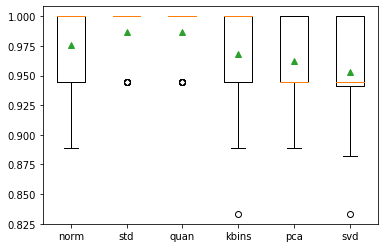

In [19]:
# plot the result
plt.boxplot(results, labels=names, showmeans=True)
plt.show()

- Summarizing the distribution of classification accuracy scores for each data preparation technique. We can see that the distribution of scores for the standardization and quantile transformations are compact and very similar and have an outlier. We can also see that the spread of scores for the other transformations are larger and skewing down.

- The results may suggest that standardizing the dataset is probably an important step in the data preparation and related transforms, such as the quantile transform, and perhaps even the power transform may offer benefits if combined with standardization by making one or more input variables more Gaussian.



# Quick Questions

In [1]:
from sklearn.datasets import load_breast_cancer

In [2]:
data=load_breast_cancer()

In [3]:
X,y=data.data,data.target

#### Q1) Print the shape of X & y data 

#### Q2) Refering code above , create Load_Dataset() function?

#### Q3) Refefring to code above , create evaluate_model() function?

#### Q4) Using Logistic Regression , create your baseline model ?

#### Q5) Print the Accuracy of the baseline model you just created above ?

#### Q6) Using Normalizer, StandardScaler, QuantileTransformer , PCA & TruncatedSVD create get_pipeline function for modeling pipeline .

**Note trye different values of n_components values ranging from 3 to 11 for both PCA & TruncatedSVD**

#### Q7) Refering to code above execute the pipeline you created and evaluate each pipeline ?

 **Author** : Himanshu Birla (https://www.linkedin.com/in/birlahimanshu/)